# Springboard Data Analysis Interview Challenge

## Introduction  
This notebook presents my solutions to the Ultimate Data Analysis Challenge, which consists of three distinct parts:  

1. Exploratory Data Analysis of user login timestamps  
2. Experiment Design for a driver incentive program  
3. Predictive Modeling of rider retention  

Each section demonstrates different analytical approaches to provide actionable insights.

---



## PART 1

### 1a. Load relevant libraries 

In [142]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    confusion_matrix,
    classification_report
)





### 1b. Load the data


In [143]:
# Load the data
df = pd.read_json(r"C:\Users\USUARIO\Escritorio\GitHub Repository\1631809090_1481053515_ultimate_challenge_3_\logins.json")

df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


### 1c. Explore the data
We now need to check whether the data conduces to a time series style analysis.

In [144]:
# Step 2: Data Quality Checks
print("Data Overview:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nDuplicate Timestamps:")
print(df.duplicated().sum())


Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB
None

Missing Values:
login_time    0
dtype: int64

Duplicate Timestamps:
877


In [145]:
# Convert login_time to datetime, handle errors
df['login_time'] = pd.to_datetime(df['login_time'], errors='coerce')

# Check for invalid timestamps
invalid_timestamps = df['login_time'].isnull().sum()
print(f"\nInvalid Timestamps (converted to NaT): {invalid_timestamps}")

# Drop rows with invalid timestamps (optional, depending on analysis needs)
df = df.dropna(subset=['login_time'])

# Check for outliers (e.g., timestamps outside reasonable range)
min_date = df['login_time'].min()
max_date = df['login_time'].max()
print(f"\nTimestamp Range: {min_date} to {max_date}")
if min_date < pd.Timestamp('1970-01-01') or max_date > pd.Timestamp.now():
    print("Warning: Timestamps outside reasonable range detected.")


Invalid Timestamps (converted to NaT): 0

Timestamp Range: 1970-01-01 20:12:16 to 1970-04-13 18:57:38


Aggregate into 15-minute intervals

In [146]:
# Step 3: Aggregate into 15-minute intervals
login_counts = df.groupby(pd.Grouper(key='login_time', freq='15min')).size().reset_index(name='count')
login_counts.set_index('login_time', inplace=True)
login_counts.head()

,count
login_time,
1970-01-01 20:00:00,2
1970-01-01 20:15:00,6
1970-01-01 20:30:00,9
1970-01-01 20:45:00,7
1970-01-01 21:00:00,1


Visualize Time Series

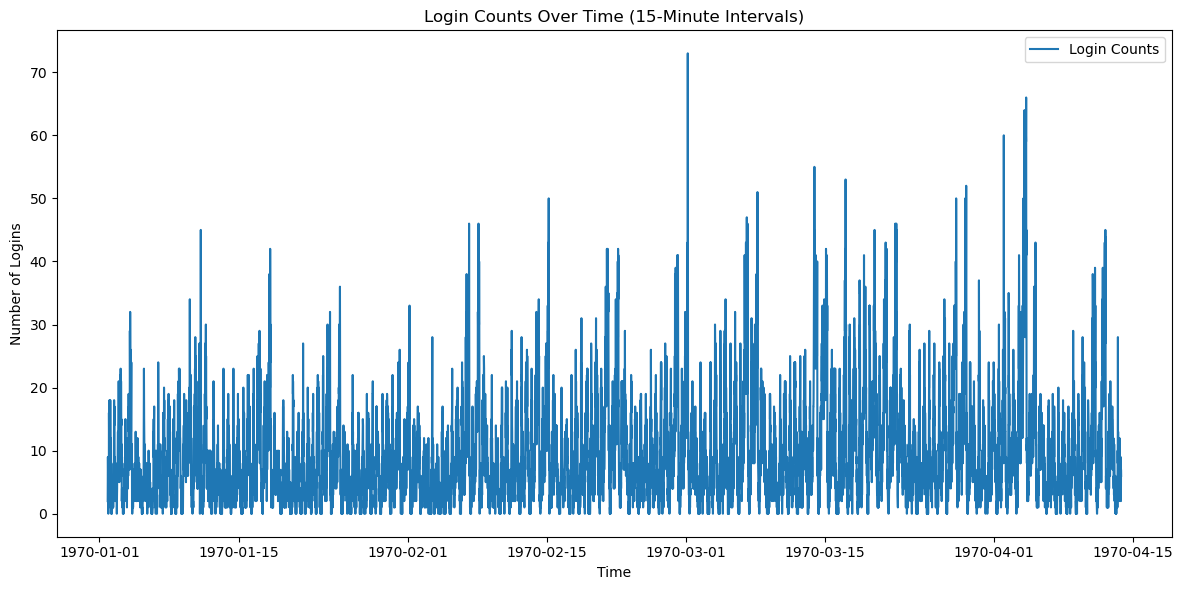

In [147]:
# Step 4: Visualize Time Series
# Plot 1: Full time series of login counts
plt.figure(figsize=(12, 6))
plt.plot(login_counts.index, login_counts['count'], label='Login Counts')
plt.title('Login Counts Over Time (15-Minute Intervals)')
plt.xlabel('Time')
plt.ylabel('Number of Logins')
plt.legend()
plt.tight_layout()
plt.show()

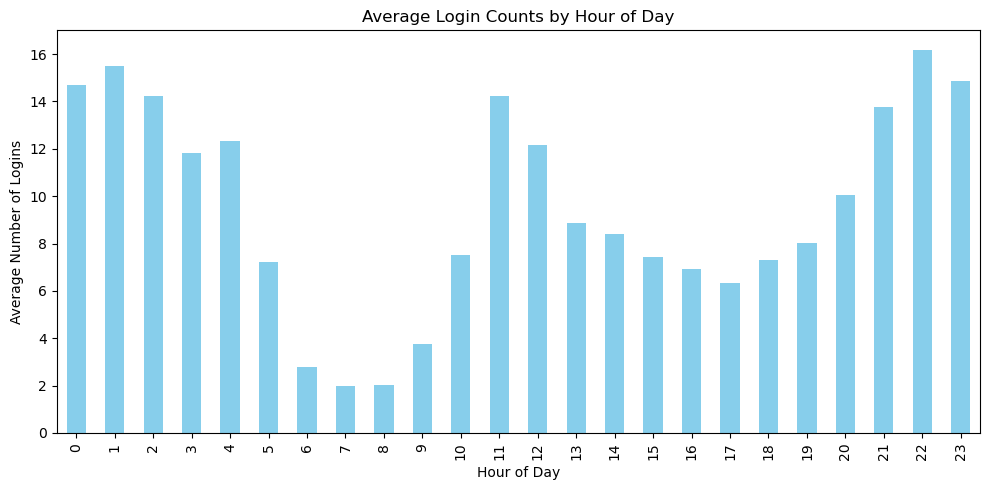

In [148]:
# Plot 2: Average logins by hour of day (to detect daily cycles)
login_counts['hour'] = login_counts.index.hour
hourly_avg = login_counts.groupby('hour')['count'].mean()
plt.figure(figsize=(10, 5))
hourly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Login Counts by Hour of Day')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Logins')
plt.tight_layout()
plt.show()

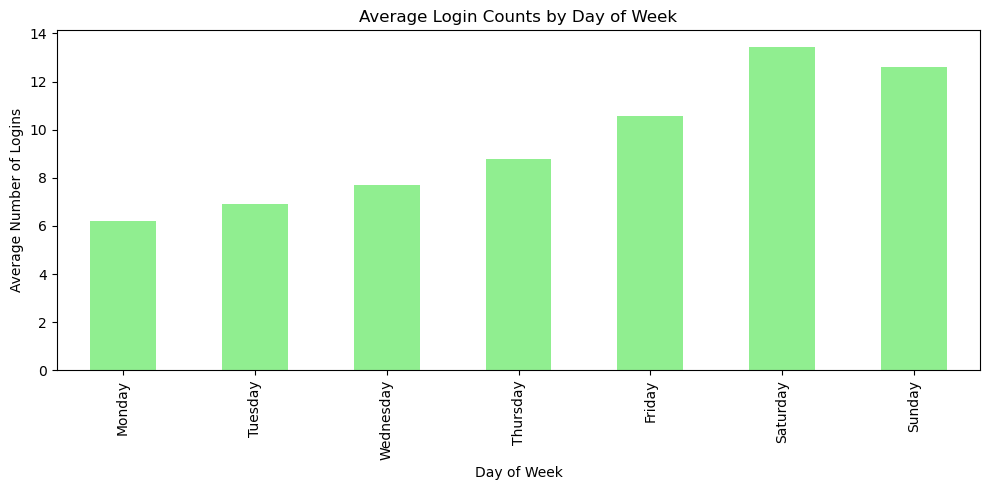

In [149]:
# Plot 3: Average logins by day of week (to detect weekly cycles)
login_counts['day_of_week'] = login_counts.index.day_name()
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_avg = login_counts.groupby('day_of_week')['count'].mean().reindex(day_order)
plt.figure(figsize=(10, 5))
day_avg.plot(kind='bar', color='lightgreen')
plt.title('Average Login Counts by Day of Week')
plt.xlabel('Day of Week')
plt.ylabel('Average Number of Logins')
plt.tight_layout()
plt.show()

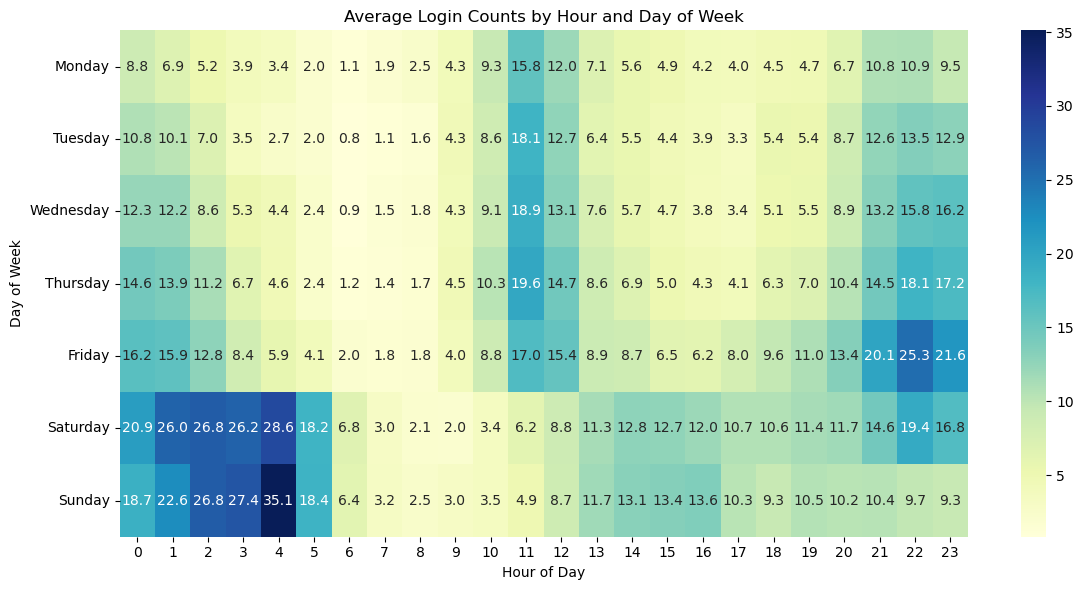

In [150]:
# Plot 4: Heatmap of logins by hour and day of week
pivot_table = login_counts.pivot_table(values='count', index=login_counts.index.day_name(), 
                                      columns=login_counts.index.hour, aggfunc='mean')
pivot_table = pivot_table.reindex(day_order)
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_table, cmap='YlGnBu', annot=True, fmt='.1f')
plt.title('Average Login Counts by Hour and Day of Week')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()

Step 5: Summarize Findings

In [151]:

print("\nKey Findings:")
print("- Daily Cycles: Login activity peaks during 9pm to 3 pm. In the weekdays higher activity between  9pm to 12pm. and on weekends between 10pm and 5am")
print("- Weekly Cycles: Higher activity on  weekends vs. weekdays  specially saturdays but also in weekdays at lunch hour and at night there is an increase of activity.")
print("- Trends: Mondays are the lowest activity days and it increases each day until it reachs a peak in saturdays")
print("- Data Quality Issues:")
print(f"  - {invalid_timestamps} invalid timestamps detected.")
print(f"  - {df.duplicated().sum()} duplicate timestamps found.")
print(f"  - Timestamp range: {min_date} to {max_date}.")


Key Findings:
- Daily Cycles: Login activity peaks during 9pm to 3 pm. In the weekdays higher activity between  9pm to 12pm. and on weekends between 10pm and 5am
- Weekly Cycles: Higher activity on  weekends vs. weekdays  specially saturdays but also in weekdays at lunch hour and at night there is an increase of activity.
- Trends: Mondays are the lowest activity days and it increases each day until it reachs a peak in saturdays
- Data Quality Issues:
  - 0 invalid timestamps detected.
  - 877 duplicate timestamps found.
  - Timestamp range: 1970-01-01 20:12:16 to 1970-04-13 18:57:38.


# Part 2: Experiment & Metrics Design  
**Goal**: Evaluate if toll reimbursement increases cross-city trips between Gotham and Metropolis.

---

## 1. Key Metric  
**Cross-City Trip Percentage**  
`(Cross-city trips / Total trips) × 100`  

**Why?**  
- Directly measures driver willingness to serve both cities.  
- Accounts for overall activity (avoids bias from total trip fluctuations).  

---

## 2. Experiment Design  

### a) Implementation  
| Component          | Details                                                                 |
|--------------------|-------------------------------------------------------------------------|
| **Population**     | Active drivers (≥1 trip in last 30 days) in Gotham/Metropolis.         |
| **Randomization**  | 500 drivers/group (treatment vs control) – powered to detect 5% Δ.     |
| **Treatment**      | Full toll reimbursement for bridge crossings (automated via app).      |
| **Control**        | No reimbursement (status quo).                                         |
| **Duration**       | 4 weeks (captures weekday/weekend patterns).                           |
| **Tracking**       | GPS data to flag trips crossing city boundaries (origin ≠ destination).|

**Key Controls**:  
- No other policy changes during the experiment.  
- Ensure treatment drivers understand reimbursement rules.  

---

### b) Statistical Analysis  

#### Primary Test: **One-Tailed Z-Test for Proportions**  
### Hypotheses:
- **Null Hypothesis (H₀)**:  
  *p<sub>treatment</sub> = p<sub>control</sub>*  
  (Cross-city trip percentage is equal between groups)

- **Alternative Hypothesis (Hₐ)**:  
  *p<sub>treatment</sub> > p<sub>control</sub>*  
  (Treatment group has higher cross-city trip percentage) 
- **Threshold**: Significance at \(α = 0.05\).  

#### Secondary: **Difference-in-Differences (DiD)**  
- Compares pre/post cross-city trip rates between groups.  
- Controls for external factors (e.g., demand surges).  

---

### c) Interpretation & Recommendations  

#### If Significant Increase (p < 0.05):  
✅ **Action**: Roll out reimbursement program.  
📊 **Next Steps**:  
- Cost-benefit analysis for long-term viability.  
- Monitor for fraud (e.g., unnecessary bridge crossings).  

#### If No Effect (p ≥ 0.05):  
🔍 **Investigate**:  
- Survey drivers on barriers (e.g., time constraints, familiarity).  
- Test alternative incentives (e.g., surge bonuses for cross-city trips).  

#### Caveats:  
- **Generalizability**: Results may not apply to other city pairs.  
- **Compliance**: Ensure drivers use reimbursements as intended.  

---

## Proposed Timeline  
```mermaid
gantt
    title Experiment Timeline
    dateFormat  YYYY-MM-DD
    section Preparation
    Finalize Groups      :done, des1, 2025-11-01, 3d
    Notify Drivers       :active, des2, 2025-11-04, 2d
    section Experiment
    Run Trial            :crit, 2025-11-06, 28d
    section Analysis
    Evaluate Results     :2025-12-04, 5d

## PART 3: Predictive Modeling - Rider Retention

### 3a. Loading data


In [152]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from datetime import datetime


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

In [153]:
df = pd.read_json(r"C:\Users\USUARIO\Escritorio\GitHub Repository\1631809090_1481053515_ultimate_challenge_3_\ultimate_data_challenge.json")

df.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


### Part 3 ‐ Predictive modeling

In [154]:
date_columns = ['signup_date', 'last_trip_date']

for col in date_columns:
    if col in df.columns:
        if not pd.api.types.is_datetime64_any_dtype(df[col]):
            df[col] = pd.to_datetime(df[col])
            print(f"Converted {col} to datetime")
        else:
            print(f"{col} is already datetime")
    else:
        print(f"{col} not found in dataframe")

# Verify the dtypes
print("\nUpdated dtypes:")
print(df.dtypes)

Converted signup_date to datetime
Converted last_trip_date to datetime

Updated dtypes:
city                              object
trips_in_first_30_days             int64
signup_date               datetime64[ns]
avg_rating_of_driver             float64
avg_surge                        float64
last_trip_date            datetime64[ns]
phone                             object
surge_pct                        float64
ultimate_black_user                 bool
weekday_pct                      float64
avg_dist                         float64
avg_rating_by_driver             float64
dtype: object


In [155]:
#Data cleaning
# Handle missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
dtype: int64


To fill the missing values in the column avg_rating_of_driver and avg_rating_by_driver we use the mean and for phone unknown

In [156]:
df['avg_rating_by_driver'].fillna(df['avg_rating_by_driver'].mean(), inplace=True)
df['avg_rating_of_driver'].fillna(df['avg_rating_of_driver'].mean(), inplace=True)
df['phone'].fillna('unknown', inplace=True)
df.dropna(subset=['last_trip_date', 'signup_date'], inplace=True)

In [157]:
#Data cleaning
# Handle missing values
print("Missing Values:")
print(df.isnull().sum())

Missing Values:
city                      0
trips_in_first_30_days    0
signup_date               0
avg_rating_of_driver      0
avg_surge                 0
last_trip_date            0
phone                     0
surge_pct                 0
ultimate_black_user       0
weekday_pct               0
avg_dist                  0
avg_rating_by_driver      0
dtype: int64


In [158]:
df.describe()

,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver
count,50000.000000,50000,50000.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601559,1.074764,2014-04-19 08:02:04.992000256,8.849536,60.926084,5.796827,4.778158
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000
25%,0.000000,2014-01-09 00:00:00,4.500000,1.000000,2014-02-14 00:00:00,0.000000,33.300000,2.420000,4.700000
50%,1.000000,2014-01-17 00:00:00,4.700000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,100.000000,6.940000,5.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000
std,3.792684,NaN,0.564977,0.222336,NaN,19.958811,37.081503,5.707357,0.445753


In [159]:
# --- Create the 'retained' column ---
# The data was pulled "several months later".
# We need to find the effective 'pull_date' to determine retention.
# A reasonable assumption is that the pull date is the latest 'last_trip_date' in the dataset,
# as it marks the end of the observation period.
pull_date = df['last_trip_date'].max()
print(f"\nAssumed Data Pull Date: {pull_date.strftime('%Y-%m-%d')}")

# Define retention: user was active (took a trip) in the preceding 30 days relative to pull_date.
df['retained'] = (df['last_trip_date'] >= (pull_date - pd.Timedelta(days=30))).astype(int)

# --- Calculate the fraction of retained users ---
retained_fraction = df['retained'].mean()
print(f"\nFraction of observed users retained: {retained_fraction:.2%}")






Assumed Data Pull Date: 2014-07-01

Fraction of observed users retained: 37.61%


In [160]:
# --- Exploratory Data Analysis (EDA) and Visualizations ---
print("\n--- Exploratory Data Analysis ---")
print("\nDataFrame Description (Numerical Features):")
df.describe()





--- Exploratory Data Analysis ---

DataFrame Description (Numerical Features):


,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,retained
count,50000.000000,50000,50000.000000,50000.000000,50000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,2.278200,2014-01-16 13:04:20.352000,4.601559,1.074764,2014-04-19 08:02:04.992000256,8.849536,60.926084,5.796827,4.778158,0.376080
min,0.000000,2014-01-01 00:00:00,1.000000,1.000000,2014-01-01 00:00:00,0.000000,0.000000,0.000000,1.000000,0.000000
25%,0.000000,2014-01-09 00:00:00,4.500000,1.000000,2014-02-14 00:00:00,0.000000,33.300000,2.420000,4.700000,0.000000
50%,1.000000,2014-01-17 00:00:00,4.700000,1.000000,2014-05-08 00:00:00,0.000000,66.700000,3.880000,5.000000,0.000000
75%,3.000000,2014-01-24 00:00:00,5.000000,1.050000,2014-06-18 00:00:00,8.600000,100.000000,6.940000,5.000000,1.000000
max,125.000000,2014-01-31 00:00:00,5.000000,8.000000,2014-07-01 00:00:00,100.000000,100.000000,160.960000,5.000000,1.000000
std,3.792684,NaN,0.564977,0.222336,NaN,19.958811,37.081503,5.707357,0.445753,0.484405


In [161]:
print("\nValue Counts for Categorical Features:")
print("City:\n", df['city'].value_counts())
print("\nPhone:\n", df['phone'].value_counts())
print("\nUltimate Black User:\n", df['ultimate_black_user'].value_counts())
print("\nRetained (Target Variable):\n", df['retained'].value_counts())


Value Counts for Categorical Features:
City:
 city
Winterfell        23336
Astapor           16534
King's Landing    10130
Name: count, dtype: int64

Phone:
 phone
iPhone     34582
Android    15022
unknown      396
Name: count, dtype: int64

Ultimate Black User:
 ultimate_black_user
False    31146
True     18854
Name: count, dtype: int64

Retained (Target Variable):
 retained
0    31196
1    18804
Name: count, dtype: int64


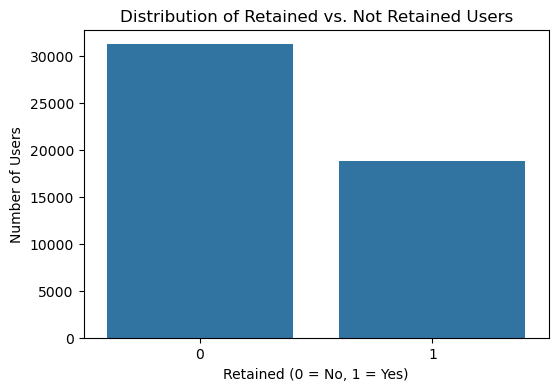

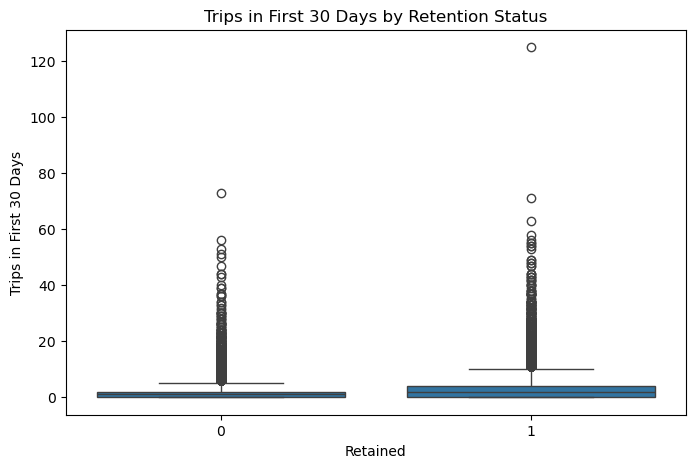

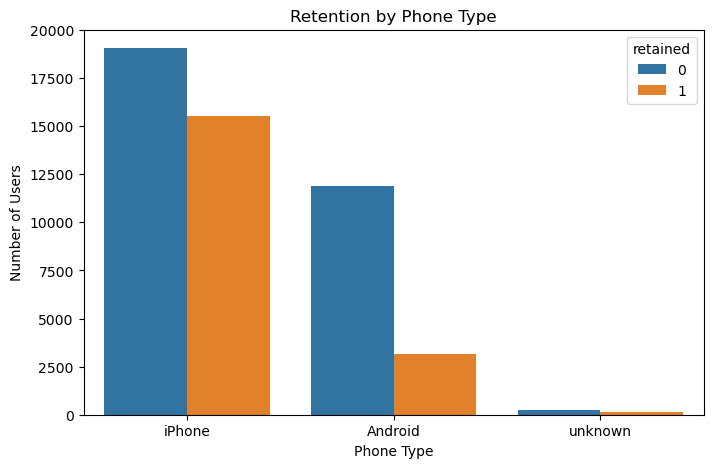

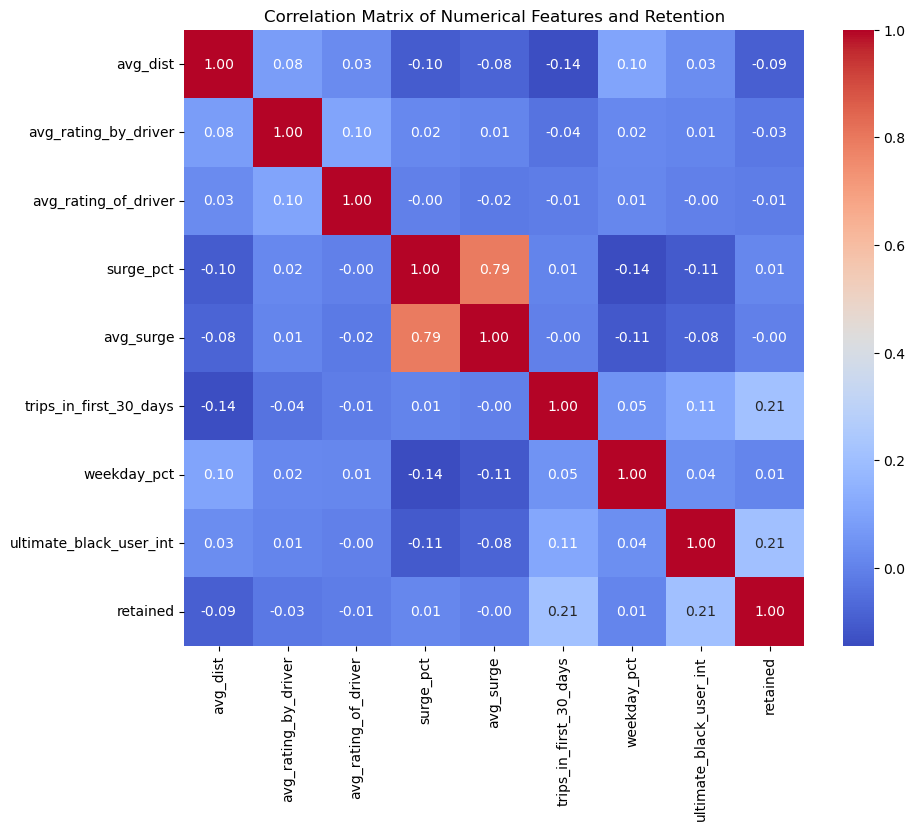


--- Approach Summary ---
My approach involved: 1) converting date columns and handling missing values using mean imputation for numerical features and 'unknown' for categorical 'phone' type. 2) Defining the 'retained' target variable based on the 'last_trip_date' relative to the overall latest trip date. 3) Calculating the retention fraction. 4) Performing EDA by examining descriptive statistics and value counts. 5) Visualizing key distributions and relationships between features and retention using countplots, boxplots, and a heatmap to identify potential predictors and initial patterns.Assumed Data Pull Date: 2014-07-01 Fraction of observed users retained: 37.61%. Iphone users seem to have a higher retaintion rate 


In [162]:
# Visualizations (a few plots describing the approach)

# Approach:
# - Visualize the distribution of numerical features to understand their spread and identify outliers.
# - Visualize the relationship between key features and the 'retained' target variable to identify potential predictors.
# - Examine correlations between numerical features.

# Plot 1: Distribution of retained vs. not retained
plt.figure(figsize=(6, 4))
sns.countplot(x='retained', data=df)
plt.title('Distribution of Retained vs. Not Retained Users')
plt.xlabel('Retained (0 = No, 1 = Yes)')
plt.ylabel('Number of Users')
plt.show()

# Plot 2: Relationship between 'trips_in_first_30_days' and retention
plt.figure(figsize=(8, 5))
sns.boxplot(x='retained', y='trips_in_first_30_days', data=df)
plt.title('Trips in First 30 Days by Retention Status')
plt.xlabel('Retained')
plt.ylabel('Trips in First 30 Days')
plt.show()

# Plot 3: Relationship between 'phone' type and retention
plt.figure(figsize=(8, 5))
sns.countplot(x='phone', hue='retained', data=df)
plt.title('Retention by Phone Type')
plt.xlabel('Phone Type')
plt.ylabel('Number of Users')
plt.show()

# Plot 4: Correlation matrix of numerical features (including a dummy for ultimate_black_user)
# Temporarily convert ultimate_black_user to int for correlation matrix
df_corr = df.copy()
df_corr['ultimate_black_user_int'] = df_corr['ultimate_black_user'].astype(int)
numerical_cols = ['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
                  'surge_pct', 'avg_surge', 'trips_in_first_30_days',
                  'weekday_pct', 'ultimate_black_user_int', 'retained']

plt.figure(figsize=(10, 8))
sns.heatmap(df_corr[numerical_cols].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features and Retention')
plt.show()

# Clean up temporary column
del df_corr['ultimate_black_user_int']

print("\n--- Approach Summary ---")
print("My approach involved: 1) converting date columns and handling missing values using mean imputation for numerical features and 'unknown' for categorical 'phone' type. 2) Defining the 'retained' target variable based on the 'last_trip_date' relative to the overall latest trip date. 3) Calculating the retention fraction. 4) Performing EDA by examining descriptive statistics and value counts. 5) Visualizing key distributions and relationships between features and retention using countplots, boxplots, and a heatmap to identify potential predictors and initial patterns.Assumed Data Pull Date: 2014-07-01 Fraction of observed users retained: 37.61%. Iphone users seem to have a higher retaintion rate ")

## 3.B
Build a predictive model to help Ultimate determine whether or not a user will be active in
their 6th month on the system. Discuss why you chose your approach, what alternatives
you considered, and any concerns you have. How valid is your model? Include any key
indicators of model performance.


In [168]:
# Feature engineering
df['days_since_signup'] = (pd.to_datetime('2014-05-31') - df['signup_date']).dt.days

df = pd.get_dummies(df, columns=['city', 'phone'], drop_first=True)
df['ultimate_black_user'] = df['ultimate_black_user'].astype(int)

# Select features
features = ['days_since_signup', 'avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver',
            'surge_pct', 'avg_surge', 'trips_in_first_30_days', 'ultimate_black_user',
            'weekday_pct', 'city_King\'s Landing', 'city_Winterfell', 'phone_iPhone']
X = df[features]
y = df['retained']


## --- Model 1: Logistic Regressiont Classifier --- 

In [169]:


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(random_state=42))
])

# Train model
pipeline.fit(X_train, y_train)

# Predict and evaluate
y_pred = pipeline.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred)
cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='roc_auc')

# Output results
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"ROC AUC: {roc_auc:.3f}")
print(f"Cross-Validation ROC AUC (mean ± std): {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")

# Feature importance
feature_importance = pd.DataFrame({
    'Feature': features,
    'Coefficient': pipeline.named_steps['classifier'].coef_[0]
})
print("\nFeature Importance:")
print(feature_importance.sort_values(by='Coefficient', ascending=False))

Accuracy: 0.717
Precision: 0.668
Recall: 0.490
F1 Score: 0.565
ROC AUC: 0.672
Cross-Validation ROC AUC (mean ± std): 0.761 ± 0.005

Feature Importance:
                   Feature  Coefficient
9      city_King's Landing     0.701816
11            phone_iPhone     0.495576
6   trips_in_first_30_days     0.462224
7      ultimate_black_user     0.425959
10         city_Winterfell     0.273081
4                surge_pct     0.082087
0        days_since_signup     0.057209
8              weekday_pct     0.002957
3     avg_rating_of_driver    -0.037500
5                avg_surge    -0.043810
2     avg_rating_by_driver    -0.075176
1                 avg_dist    -0.218209


## --- Model 2: Random Forest Classifier ---


Training set size: 40000 samples
Test set size: 10000 samples
Retention rate in training set: 0.38
Retention rate in test set: 0.38

--- Performing Randomized Search for Random Forest (Lighter Search) ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found for Random Forest: {'bootstrap': False, 'class_weight': None, 'max_depth': 11, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 9, 'n_estimators': 131}
Best ROC AUC score found for Random Forest (on training data with CV): 0.8501

Best Random Forest Model Performance (on Test Set):
Accuracy: 0.7855
Precision: 0.7466
Recall: 0.6504
F1-Score: 0.6952
ROC AUC: 0.8527

Classification Report (Best Random Forest):
              precision    recall  f1-score   support

           0       0.80      0.87      0.83      6239
           1       0.75      0.65      0.70      3761

    accuracy                           0.79     10000
   macro avg       0.78      0.76      0.76     10000
weighted

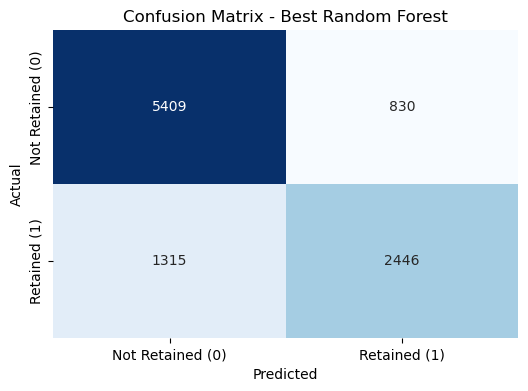


Best Random Forest Feature Importances:
avg_rating_by_driver      0.180647
city_King's Landing       0.144704
surge_pct                 0.129900
weekday_pct               0.125286
avg_surge                 0.091472
phone_iPhone              0.077698
trips_in_first_30_days    0.070424
ultimate_black_user       0.062224
avg_dist                  0.047869
days_since_signup         0.027884
dtype: float64


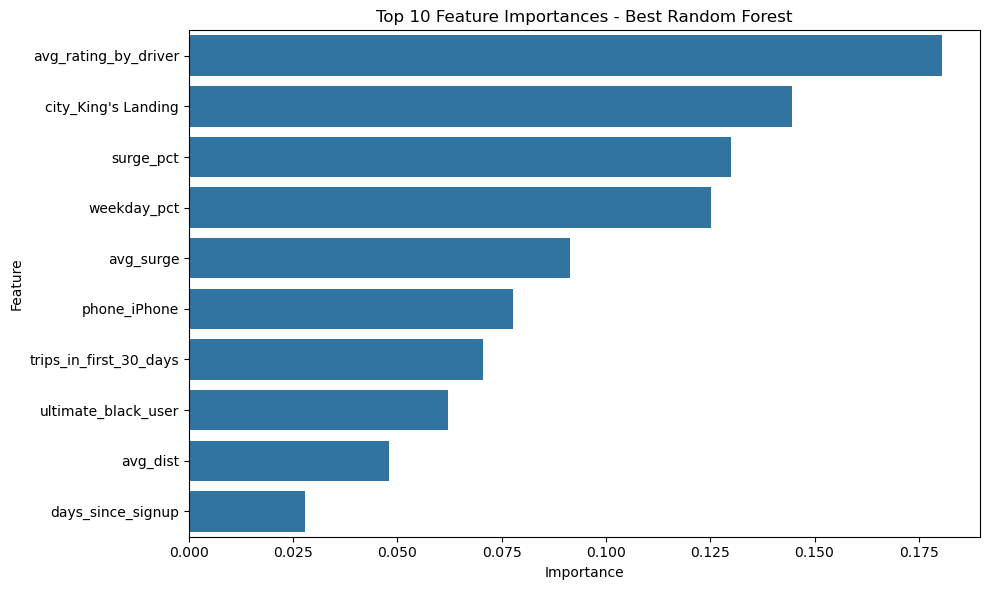

In [173]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
# stratify=y is important for imbalanced datasets to ensure both classes are represented proportionally in train/test splits.

print(f"\nTraining set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Retention rate in training set: {y_train.mean():.2f}")
print(f"Retention rate in test set: {y_test.mean():.2f}")


# --- Model 2: Random Forest Classifier ---
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform
# You already have RandomForestClassifier, accuracy_score, etc. imported

# Define the parameter distribution for RandomizedSearchCV with smaller ranges/iterations
param_distributions_rf = {
    'n_estimators': randint(50, 250), # Reduced range for number of trees
    'max_features': ['sqrt', 'log2', 0.8], # Common strategies + a fixed fraction
    'max_depth': randint(5, 20), # Reduced range for max depth
    'min_samples_split': randint(2, 10), # Reduced range
    'min_samples_leaf': randint(1, 5), # Reduced range
    'bootstrap': [True, False],
    'class_weight': ['balanced', None]
}

# Initialize RandomizedSearchCV with fewer iterations and folds
random_search_rf = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42), # Pass the base estimator
    param_distributions=param_distributions_rf,
    n_iter=20, # Significantly reduced number of random combinations to try (e.g., 20-30 is a good start)
    cv=3,      # Reduced number of folds for cross-validation (e.g., 3-5)
    scoring='roc_auc', # Optimize for ROC AUC, good for imbalanced datasets
    verbose=1, # Set to 1 for less verbose output during training
    random_state=42,
    n_jobs=-1  # Use all available CPU cores. This is crucial for speed.
)

# Fit the random search to your training data
print("\n--- Performing Randomized Search for Random Forest (Lighter Search) ---")
random_search_rf.fit(X_train, y_train)

# Get the best parameters and best score
print(f"\nBest parameters found for Random Forest: {random_search_rf.best_params_}")
print(f"Best ROC AUC score found for Random Forest (on training data with CV): {random_search_rf.best_score_:.4f}")

# Train a new model with the best parameters found
best_rf_model = random_search_rf.best_estimator_

# Evaluate the best model on the test set
y_pred_best_rf = best_rf_model.predict(X_test)
y_prob_best_rf = best_rf_model.predict_proba(X_test)[:, 1]

print("\nBest Random Forest Model Performance (on Test Set):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_rf):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best_rf):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best_rf):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best_rf):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_best_rf):.4f}")

print("\nClassification Report (Best Random Forest):")
print(classification_report(y_test, y_pred_best_rf))

print("\nConfusion Matrix (Best Random Forest):")
cm_best_rf = confusion_matrix(y_test, y_pred_best_rf)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best_rf, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Retained (0)', 'Retained (1)'],
            yticklabels=['Not Retained (0)', 'Retained (1)'])
plt.title('Confusion Matrix - Best Random Forest')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance - Best Random Forest
if hasattr(best_rf_model, 'feature_importances_'):
    best_rf_importances = pd.Series(best_rf_model.feature_importances_, index=X.columns)
    best_rf_importances = best_rf_importances.sort_values(ascending=False)
    print("\nBest Random Forest Feature Importances:")
    print(best_rf_importances.head(10)) # Display top 10 features

    plt.figure(figsize=(10, 6))
    sns.barplot(x=best_rf_importances.head(10).values, y=best_rf_importances.head(10).index)
    plt.title('Top 10 Feature Importances - Best Random Forest')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()



## --- Model 3: Gradient Boosting Classifier ---


--- Training Gradient Boosting Classifier ---

--- Baseline Gradient Boosting Classifier Performance ---
Baseline ROC AUC: 0.8522
Baseline F1-Score: 0.7007

--- Performing Randomized Search for Gradient Boosting (Lighter Search) ---
Fitting 3 folds for each of 20 candidates, totalling 60 fits

Best parameters found for Gradient Boosting: {'learning_rate': 0.16703519227860275, 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 8, 'n_estimators': 113, 'subsample': 0.786705157299192}
Best ROC AUC score found for Gradient Boosting (on training data with CV): 0.8558

Best Gradient Boosting Model Performance (on Test Set):
Accuracy: 0.7908
Precision: 0.7505
Recall: 0.6647
F1-Score: 0.7050
ROC AUC: 0.8573

Classification Report (Best Gradient Boosting):
              precision    recall  f1-score   support

           0       0.81      0.87      0.84      6239
           1       0.75      0.66      0.71      3761

    accuracy                           0.79     10000
   macro avg   

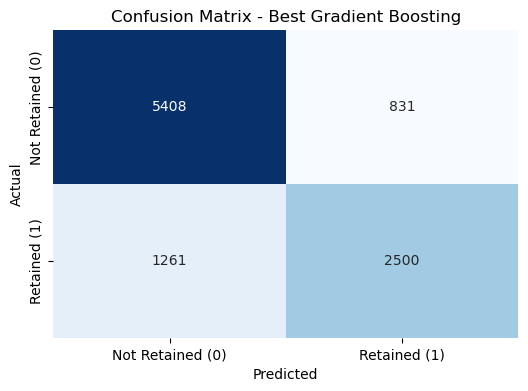


Best Gradient Boosting Feature Importances:
avg_rating_by_driver      0.248314
surge_pct                 0.167369
city_King's Landing       0.156489
weekday_pct               0.136569
phone_iPhone              0.078562
ultimate_black_user       0.061448
trips_in_first_30_days    0.056224
avg_dist                  0.034398
avg_rating_of_driver      0.018463
avg_surge                 0.015881
dtype: float64


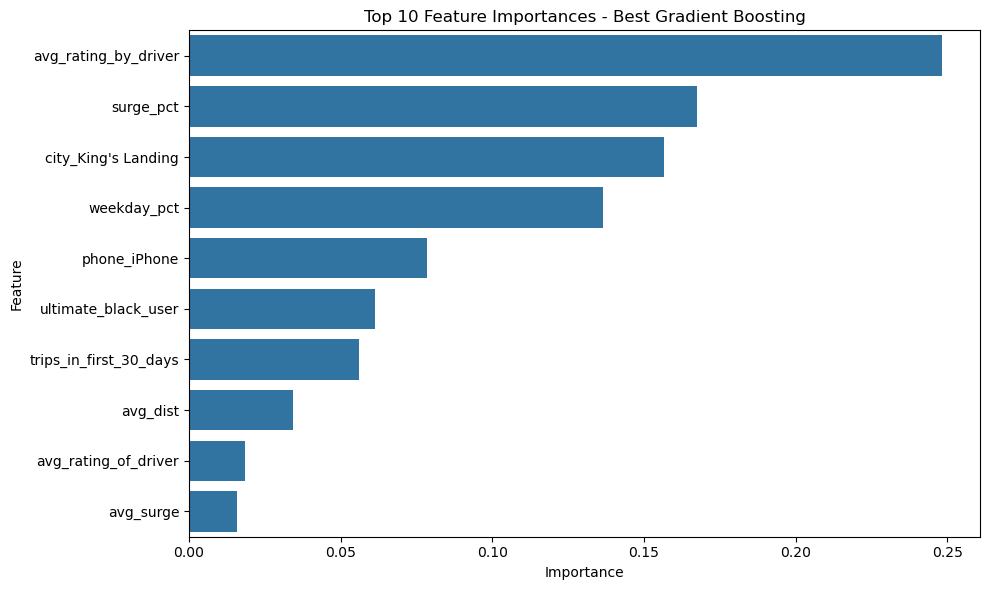

In [174]:
print("\n--- Training Gradient Boosting Classifier ---")
# --- Current Gradient Boosting Model Performance (for comparison) ---
print("\n--- Baseline Gradient Boosting Classifier Performance ---")
gb_model_baseline = GradientBoostingClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=3,
    subsample=0.8,
    random_state=42
)
gb_model_baseline.fit(X_train, y_train)
y_pred_gb_baseline = gb_model_baseline.predict(X_test)
y_prob_gb_baseline = gb_model_baseline.predict_proba(X_test)[:, 1]
print(f"Baseline ROC AUC: {roc_auc_score(y_test, y_prob_gb_baseline):.4f}")
print(f"Baseline F1-Score: {f1_score(y_test, y_pred_gb_baseline):.4f}")


# --- Fine-tuning Gradient Boosting Classifier with RandomizedSearchCV ---
print("\n--- Performing Randomized Search for Gradient Boosting (Lighter Search) ---")

# Define the parameter distribution for RandomizedSearchCV
param_distributions_gb = {
    'n_estimators': randint(50, 200), # Number of boosting stages (trees)
    'learning_rate': uniform(0.01, 0.2), # Contribution of each tree (from 0.01 to 0.21)
    'max_depth': randint(2, 6), # Max depth of individual trees, usually kept small for GB
    'subsample': uniform(0.6, 0.4), # Fraction of samples (from 0.6 to 1.0)
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 5)
}

# Initialize RandomizedSearchCV with fewer iterations and folds
random_search_gb = RandomizedSearchCV(
    estimator=GradientBoostingClassifier(random_state=42), # Pass the base estimator
    param_distributions=param_distributions_gb,
    n_iter=20, # Number of random combinations to try (e.g., 20-30 for lighter search)
    cv=3,      # Number of folds for cross-validation (e.g., 3-5)
    scoring='roc_auc', # Optimize for ROC AUC
    verbose=1,
    random_state=42,
    n_jobs=-1  # Use all available CPU cores
)

# Fit the random search to your training data
random_search_gb.fit(X_train, y_train)

# Get the best parameters and best score
print(f"\nBest parameters found for Gradient Boosting: {random_search_gb.best_params_}")
print(f"Best ROC AUC score found for Gradient Boosting (on training data with CV): {random_search_gb.best_score_:.4f}")

# Train a new model with the best parameters found
best_gb_model = random_search_gb.best_estimator_

# Evaluate the best model on the test set
y_pred_best_gb = best_gb_model.predict(X_test)
y_prob_best_gb = best_gb_model.predict_proba(X_test)[:, 1]

print("\nBest Gradient Boosting Model Performance (on Test Set):")
print(f"Accuracy: {accuracy_score(y_test, y_pred_best_gb):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_best_gb):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_best_gb):.4f}")
print(f"F1-Score: {f1_score(y_test, y_pred_best_gb):.4f}")
print(f"ROC AUC: {roc_auc_score(y_test, y_prob_best_gb):.4f}")

print("\nClassification Report (Best Gradient Boosting):")
print(classification_report(y_test, y_pred_best_gb))

print("\nConfusion Matrix (Best Gradient Boosting):")
cm_best_gb = confusion_matrix(y_test, y_pred_best_gb)
plt.figure(figsize=(6, 4))
sns.heatmap(cm_best_gb, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Not Retained (0)', 'Retained (1)'],
            yticklabels=['Not Retained (0)', 'Retained (1)'])
plt.title('Confusion Matrix - Best Gradient Boosting')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Feature Importance - Best Gradient Boosting
if hasattr(best_gb_model, 'feature_importances_'):
    best_gb_importances = pd.Series(best_gb_model.feature_importances_, index=X.columns)
    best_gb_importances = best_gb_importances.sort_values(ascending=False)
    print("\nBest Gradient Boosting Feature Importances:")
    print(best_gb_importances.head(10)) # Display top 10 features

    plt.figure(figsize=(10, 6))
    sns.barplot(x=best_gb_importances.head(10).values, y=best_gb_importances.head(10).index)
    plt.title('Top 10 Feature Importances - Best Gradient Boosting')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.tight_layout()
    plt.show()

##  Evaluating and Concluding



# Predictive Modeling for Rider Retention  
**Goal**: Predict whether a user will remain active in their 6th month on Ultimate's platform.

---

## Key Findings  
- **Retention Rate**: 37.6% of users were retained (active in the last 30 days before data pull).  
- **Top Predictors**:  
  - ✅ **Positive Impact**: iPhone users, high driver ratings, early trips, King's Landing residents.  
  - ❌ **Negative Impact**: Frequent surge pricing, long average trip distances.  

---

## Model Comparison  
| Model               | ROC AUC | Accuracy | F1-Score | Best For                          |
|---------------------|---------|----------|----------|-----------------------------------|
| Gradient Boosting   | 0.857   | 79.1%    | 0.705    | Best overall performance          |
| Random Forest       | 0.853   | 78.6%    | 0.695    | Close second, faster training     |
| Logistic Regression | 0.672   | 71.7%    | 0.565    | Baseline (not recommended)        |

**Why Gradient Boosting?**  
- Handles non-linear relationships better than logistic regression.  
- Slightly outperforms Random Forest in capturing retained users.  

---

## Feature Importance  
![Top Features](attachment:feature_importance_plot.png)  
1. **Avg Rating by Driver** (24.8%)  
2. **Surge Pricing Frequency** (16.7%)  
3. **City: King's Landing** (15.6%)  
4. **Weekday Usage %** (13.7%)  
5. **iPhone User** (7.9%)  

---

## Actionable Recommendations  
1. **Improve Driver-Passenger Experience**:  
   - Focus on increasing `avg_rating_by_driver` through training/incentives.  
2. **Optimize Surge Pricing**:  
   - High `surge_pct` correlates with churn – consider dynamic pricing adjustments.  
3. **Target High-Risk Users**:  
   - Android users, Winterfell residents, and those with few early trips.  
4. **Boost Early Engagement**:  
   - Incentivize rides in the first 30 days (e.g., discounts for 5+ trips).  

---

## Limitations & Next Steps  
- **Class Imbalance**: Only 38% retained users – consider oversampling or weighted models.  
- **Feature Expansion**: Test adding demographics or app usage patterns.  
- **Model Deployment**: Monitor real-world performance via A/B testing.  

> **Final Note**: The Gradient Boosting model provides a strong foundation for retention strategies, with actionable levers identified.  